In [82]:
using PyPlot, Statistics
using ClimateMARGO

In [83]:
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting
using ClimateMARGO.PolicyResponse
include("ebm.jl");

# Policy scenario: SRM termination in 2050

In [84]:
SRM = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

In [86]:
max_update = Dict("mitigate"=>nothing, "remove"=>nothing, "geoeng"=>1., "adapt"=>0.1);
max_deployment_noSRM = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>0., "adapt"=>0.4);

In [87]:
optimize_controls!(SRM, obj_option="net_benefit", max_slope=max_slope);

Solve_Succeeded


In [88]:
noSRM = deepcopy(SRM)
optimize_controls!(
    noSRM, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM
);

Solve_Succeeded


In [89]:
SRM_term = deepcopy(SRM)
step_forward!(SRM_term, 40.)
terminate_year = Int(SRM_term.domain.present_year)

2060

In [90]:
optimize_controls!(
    SRM_term, obj_option="net_benefit",
    max_deployment=max_deployment_noSRM, max_update=max_update
);
SRM_term.domain.present_year = 2020.;

Solve_Succeeded


In [91]:
using Interpolations

F_lo = F(SRM_term, M=true, R=true, G=true);
t_lo = t(SRM_term)

Δt = 0.1
t_hi = 2020.:Δt:2200.

itp = interpolate((t_lo,), F_lo, Gridded(Linear()))
F_hi = itp(t_hi);

itp = interpolate((t_lo,), SRM_term.controls.adapt, Gridded(Linear()))
A_hi = itp(t_hi);

T_hi = DICE_EBM(t_hi, F_hi, default="Geoffroy-2013", Δt=Δt) .+ SRM_term.physics.T0;

### Plots and calculations

In [92]:
using PyCall
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j);

##### Modified damage functions

In [93]:
damage(β, E, T, A, c, dt; discount=1., βCO2=0., βdTdt=0.) = ((1. .- A) .* ( (β .* E .* T.^2) .+ (βCO2 .* E .* (c.-280.)) .+ insert!(βdTdt .* (E[1:end-1] .+ E[2:end])/2. .* (diff(T)./dt).^2, 1, 0.) )) .* discount

damage(m; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = damage(
    m.economics.β,
    E(m),
    T(m, M=M, R=R, G=G, A=A),
    0.,
    c(m, M=M, R=R),
    m.domain.dt,
    discount=1. .+ discounting * (discount(m) .- 1.),
    βCO2=βCO2,
    βdTdt=βdTdt
)

benefit(damage_baseline, damage) = damage_baseline .- damage
benefit(m::ClimateModel; discounting=false, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = benefit(
    damage(m, discounting=discounting, βCO2=βCO2, βdTdt=βdTdt),
    damage(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt)
)

net_benefit(benefit, cost) = benefit .- cost
net_benefit(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_benefit(
    benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    cost(m, discounting=discounting, M=M, R=R, G=G, A=A)
)

net_present_benefit_mod(net_benefit, dt) = sum(net_benefit*dt)
net_present_benefit_mod(m::ClimateModel; discounting=true, M=false, R=false, G=false, A=false, βCO2=0., βdTdt=0.) = net_present_benefit_mod(
    net_benefit(m, discounting=discounting, M=M, R=R, G=G, A=A, βCO2=βCO2, βdTdt=βdTdt),
    m.domain.dt
)

net_present_benefit_mod (generic function with 2 methods)

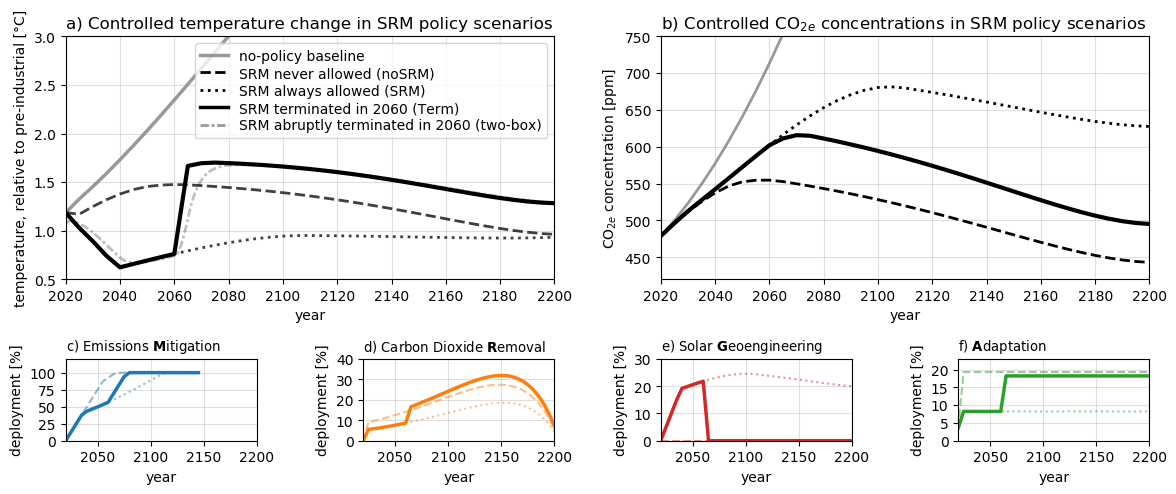

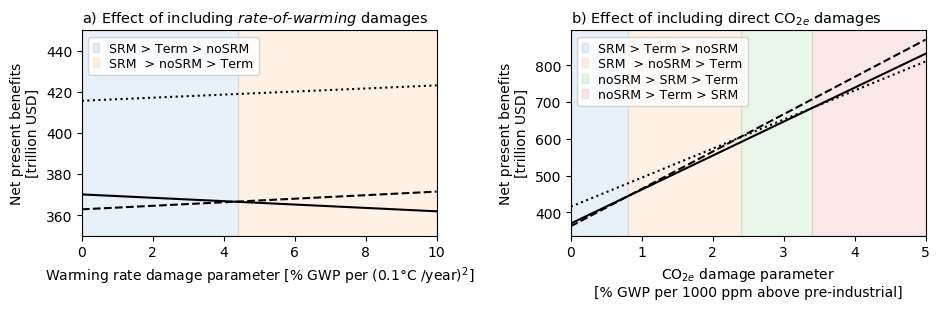

In [108]:
fig1 = figure(figsize=(12,5))
gs = fig1.add_gridspec(6, 8)

##
ax1 = fig1.add_subplot(get(gs, (slice(0,4), slice(0,4))))

ax2 = fig1.add_subplot(get(gs,(slice(4,6), slice(0,2))))
ax2.set_ylim(0, 120)
ax2.set_yticks([0, 25, 50, 75, 100])

ax3 = fig1.add_subplot(get(gs,(slice(4,6), slice(2,4))))
ax3.set_ylim(0, 40)
ax3.set_yticks([0, 10, 20, 30, 40])

ax4 = fig1.add_subplot(get(gs,(slice(4,6), slice(4,6))))
ax4.set_ylim(0, 30)
ax4.set_yticks([0, 10, 20, 30])

ax5 = fig1.add_subplot(get(gs,(slice(4,6), slice(6,8))))
ax5.set_ylim(0, 23)
ax5.set_yticks([0, 5, 10, 15, 20])

ax6 = fig1.add_subplot(get(gs, (slice(0,4), slice(4,8))))

fig2 = figure(figsize=(9.5, 3.2))
ax7 = fig2.add_subplot(1,2,1)
ax8 = fig2.add_subplot(1,2,2)

for ax in [ax1, ax2, ax3, ax4, ax5]
    ax.grid(true, alpha=0.4)
    ax.set_xlim(2020., 2200.)
    ax.set_xlabel("year")
end

for ax in [ax2, ax3, ax4, ax5]
    ax.set_ylabel("deployment [%]")
end

##
ax1.plot(t(SRM),T(SRM), "-", color="grey", label="no-policy baseline", lw=2.5, alpha=0.8)
m = noSRM
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", ls="--", lw=2, alpha=0.75)
m = SRM
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", alpha=0.75, ls=":", lw=2)
m = SRM_term
ax1.plot(t_hi, T_hi.*sqrt.(1 .-A_hi), color="k", lw=2., ls=(0., (3,1,1,1)), alpha=0.25)
ax1.plot(t(m),T(m, M=true, R=true, G=true, A=true), color="k", lw=3, ls="-")

ax1.plot([],[], lw=2, ls="--", color="k", label="SRM never allowed (noSRM)")
ax1.plot([],[], lw=2, ls=":", color="k", label="SRM always allowed (SRM)")
ax1.plot([],[], lw=2.5, ls="-", color="k", label="SRM terminated in $(terminate_year) (Term)")
ax1.plot([],[], lw=2., alpha=0.4, ls=(0., (3,1,1,1)), color="k", label="SRM abruptly terminated in $(terminate_year) (two-box)")

ax1.legend(loc="upper right", labelspacing=0.25)
ax1.set_ylim([0.5, 3.0])
ax1.set_ylabel("temperature, relative to pre-industrial [°C]")
ax1.set_title("a) Controlled temperature change in SRM policy scenarios", loc="left")

## 
m = noSRM
qidx = (m.economics.baseline_emissions .> 0)
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="--", lw=1.5, alpha=0.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="--", lw=1.5, alpha=0.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="--", lw=1.5, alpha=0.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="--", lw=1.5, alpha=0.5)

m = SRM
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls=":", lw=1.5, alpha=0.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls=":", lw=1.5, alpha=0.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls=":", lw=1.5, alpha=0.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls=":", lw=1.5, alpha=0.5)

m = SRM_term
ax2.plot(t(m)[qidx], m.controls.mitigate[qidx]*100, color="C0", ls="-", lw=2.5)
ax3.plot(t(m), m.controls.remove*100, color="C1", ls="-", lw=2.5)
ax4.plot(t(m), m.controls.geoeng*100, color="C3", ls="-", lw=2.5)
ax5.plot(t(m), m.controls.adapt*100, color="C2", ls="-", lw=2.5)

ax2.set_title(L"c) Emissions $\mathbf{M}$itigation", fontsize=9.5, loc="left")
ax3.set_title(L"d) Carbon Dioxide $\mathbf{R}$emoval", fontsize=9.5, loc="left")
ax4.set_title(L"e) Solar $\mathbf{G}$eoengineering", fontsize=9.5, loc="left")
ax5.set_title(L"f) $\mathbf{A}$daptation", fontsize=9.5, loc="left")

##
m = noSRM
ax6.plot(t(SRM), c(SRM), "-", color="grey", lw=2, alpha=0.8)
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="--", lw=2)
m = SRM
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls=":", lw=2)
m = SRM_term
ax6.plot(t(m),c(m, M=true, R=true), color="k", ls="-", lw=3)
ax6.set_ylim(420, 750)

ax6.grid(true, alpha=0.4)
ax6.set_xlim(2020., 2200.)
ax6.set_xlabel("year")
ax6.set_ylabel(L"CO$_{2e}$ concentration [ppm]")
ax6.set_title(L"b) Controlled CO$_{2e}$ concentrations in SRM policy scenarios", loc="left")

fig1.tight_layout()
fig1.savefig("figures/SRM_termination_response.png", dpi=200., bbox_inches="tight")

##
βdTdtmax = (10. /100.) / (1. /10.) # 5% GWP damages for 1ºC warming in 10 years
βdTdts = 0.:βdTdtmax/50.:βdTdtmax;

NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βdTdt=βdTdt) for βdTdt in βdTdts]


ax7.plot(βdTdts, NPB_mod_SRM_term, "k-")
ax7.plot(βdTdts, NPB_mod_noSRM, "k--")
ax7.plot(βdTdts, NPB_mod_SRM, "k:")
ax7.set_xlim(βdTdts[1], βdTdts[end])
ax7.set_ylim(350, 450)
yl = ax7.get_ylim()
xt = βdTdts[1]:βdTdts[end]/5:βdTdts[end]
ax7.set_xticks(xt)
ax7.set_xticklabels(Int.(xt*100*(1/10.)))

_, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
ax7.fill_between([0, βdTdts[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.1, color="C0", label="SRM > Term > noSRM")
ax7.fill_between([βdTdts[i1], βdTdts[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C1", alpha=0.1, label="SRM  > noSRM > Term")

ax7.set_ylim(yl)
ax7.set_ylabel("Net present benefits\n[trillion USD]")
ax7.set_xlabel(L"Warming rate damage parameter [% GWP per (0.1°C /year)$^{2}$]")
ax7.set_title(L"a) Effect of including $rate$-$of$-$warming$ damages", loc="left", fontsize=10.5)
ax7.legend(labelspacing=0.2, handlelength=0.5, fontsize=9, loc="upper left")

##
βCO2max = (5. /100.) / 1000. # 5% GWP damages for 1000 ppm increase in CO2
βCO2s = 0.:βCO2max/50.:βCO2max;

NPB_mod_SRM_term = [net_present_benefit_mod(SRM_term, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_noSRM = [net_present_benefit_mod(noSRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]
NPB_mod_SRM = [net_present_benefit_mod(SRM, M=true, R=true, G=true, A=true, βCO2=βCO2) for βCO2 in βCO2s]

ax8.plot(βCO2s, NPB_mod_SRM_term, "k-")
ax8.plot(βCO2s, NPB_mod_noSRM, "k--")
ax8.plot(βCO2s, NPB_mod_SRM, "k:")
ax8.set_xlim(βCO2s[1], βCO2s[end])
yl = ax8.get_ylim()
xt = βCO2s[1]:βCO2s[end]/5:βCO2s[end]
ax8.set_xticks(xt)
ax8.set_xticklabels(Int.(xt*100*1000))

_, i1 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_noSRM))
ax8.fill_between([0, βCO2s[i1]], [yl[1], yl[1]], [yl[2], yl[2]], alpha=0.1, color="C0", label="SRM > Term > noSRM")

_, i2 = findmin(abs.(NPB_mod_SRM .- NPB_mod_noSRM))
ax8.fill_between([βCO2s[i1], βCO2s[i2]], [yl[1], yl[1]], [yl[2], yl[2]], color="C1", alpha=0.1, label="SRM  > noSRM > Term")

_, i3 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
ax8.fill_between([βCO2s[i2], βCO2s[i3]], [yl[1], yl[1]], [yl[2], yl[2]], color="C2", alpha=0.1, label="noSRM > SRM > Term")

_, i4 = findmin(abs.(NPB_mod_SRM_term .- NPB_mod_SRM))
ax8.fill_between([βCO2s[i3], βCO2s[end]], [yl[1], yl[1]], [yl[2], yl[2]], color="C3", alpha=0.1, label="noSRM > Term > SRM")

ax8.set_ylim(yl)
ax8.set_ylabel("Net present benefits\n[trillion USD]")
ax8.set_xlabel(string(
    L"CO$_{2e}$ damage parameter",
    "\n[% GWP per 1000 ppm above pre-industrial]"
))
ax8.set_title(L"b) Effect of including direct CO$_{2e}$ damages", loc="left", fontsize=10.5)
ax8.legend(labelspacing=0.2, handlelength=0.5, fontsize=9, loc="upper left")

fig2.tight_layout()
fig2.savefig("figures/SRM_termination_sensitivity.png", dpi=200., bbox_inches="tight")